## Import the libraries and load in the data

### Importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import re
import itertools
import os
from collections import defaultdict
import string
from functools import partial

import nltk
from tqdm import tqdm
import spacy

import xgboost as xgb
import lightgbm as lgb

from sklearn import model_selection, ensemble, linear_model, svm
from sklearn import metrics, manifold, decomposition, tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

### Constants

In [2]:
SEED = 2406
TEST_SIZE = 0.15
VOCAB_SIZE = 2000

SHOULD_SAVE = False
SHOULD_DOWNLOAD = False

### Loading the data

## Forming the target class
* Let's just take the `tag1` column for now as the target
* **Similar tags are grouped** so that there is relatively less number of classes and also the count of each class is made large enough such that the model can learn enough from the instances to identify the particular tag

In [3]:
qns = pd.read_csv("../datasets/array_graph_string.csv")
qns.rename(columns={'tag1':'tag','stop_words_removed_qns':'qn'}, inplace=True)

In [4]:
qns["tag"].unique(), qns["tag"].nunique()

(array(['graph', 'array', 'string'], dtype=object), 3)

## Preprocessing

The questions will be preprocessed using the following steps,
* Removing punctuations ([] will not be removed)
* Any URLs if present will be removed
* Stop words will be removed
* Lower casing
* Stop word removal
* Lemmatization 

### Removing punctuations

In [5]:
print(f"Punctuation symbols: {string.punctuation}")

puncts = string.punctuation

idx_open = puncts.index('[')
puncts = puncts[:idx_open] + puncts[idx_open+1:]

idx_closed = puncts.index(']')
puncts = puncts[:idx_closed] + puncts[idx_closed+1:]

print(puncts)

Punctuation symbols: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@\^_`{|}~


In [6]:
qns

,qn,tag
0,Andrew love sea that s height summer season de...,graph
1,you give tree consist n vertex Initially verte...,graph
2,monocarp playing Minecraft want build wall cac...,graph
3,you give rooted tree consist n vertex the vert...,graph
4,you give n segment coordinate axis the ith seg...,array
...,...,...
3007,give integer array num positive integer return...,array
3008,you give 0indexed array num size n consist non...,array
3009,you give integer array num integer k find maxi...,array
3010,you give 0indexed integer array cost costsi co...,array


In [7]:
def remove_punctuation(text):
  new_text = "".join([t for t in text if t not in puncts])
  return new_text

qns['qn'] = qns['qn'].apply(lambda qn:remove_punctuation(qn))

### Lower casing the text

Lower casing the text reduces the vocabulary size and it also makes sure that two same words in different cases are not treated as different words

In [8]:
qns['qn'] = qns['qn'].str.lower()

### Stop word removal

In [9]:
if SHOULD_DOWNLOAD:
    nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [10]:
def remove_stopwords(text):
  new_text = [word for word in text.split(' ') if word not in stopwords]
  return ' '.join(new_text)

In [11]:
qns['qn'] = qns['qn'].apply(lambda qn: remove_stopwords(qn))

### Lemmatization

In [12]:
if SHOULD_DOWNLOAD:
    nltk.download('omw-1.4')
    nltk.download('wordnet')
wn_lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatizer(text):
  new_text = [wn_lemmatizer.lemmatize(word) for word in text.split(' ')]
  return ' '.join(new_text)

In [13]:
qns['qn'] = qns['qn'].apply(lambda qn: lemmatizer(qn))

In [14]:
len_of_qns = qns['qn'].str.split().apply(lambda qn: len(qn))

In [15]:
print(f"Mean length of a qn: {len_of_qns.mean()}")
print(f"Max length of a qn: {len_of_qns.max()}")
print(f"Min length of a qn: {len_of_qns.min()}")

Mean length of a qn: 87.66965471447543
Max length of a qn: 789
Min length of a qn: 8


Text(0.5, 1.0, 'Distribution of lengths')

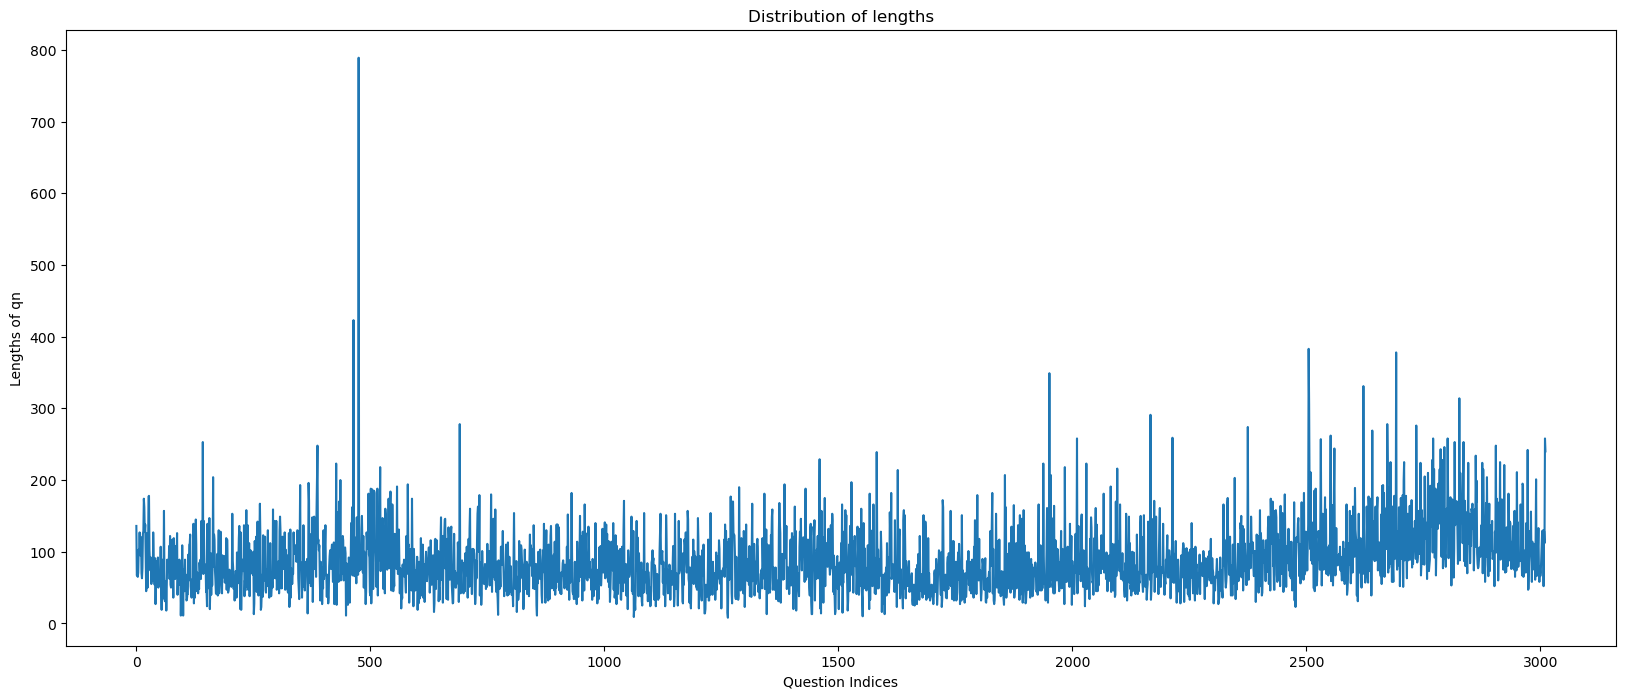

In [16]:
plt.figure(figsize=(20,8))
plt.plot(len_of_qns)
plt.xlabel('Question Indices')
plt.ylabel('Lengths of qn')
plt.title("Distribution of lengths")

We notice that the minimum length for a question is 2, which is definitely an outlier. <br>
Let's trim the dataset so that the minimum length is 15. 

In [17]:
less_than_15_idx = len_of_qns[len_of_qns<15].index
qns.drop(less_than_15_idx, inplace=True)

In [18]:
qns.reset_index(drop=True, inplace=True)

Let's look at the distribution again

Text(0.5, 1.0, 'Distribution of lengths')

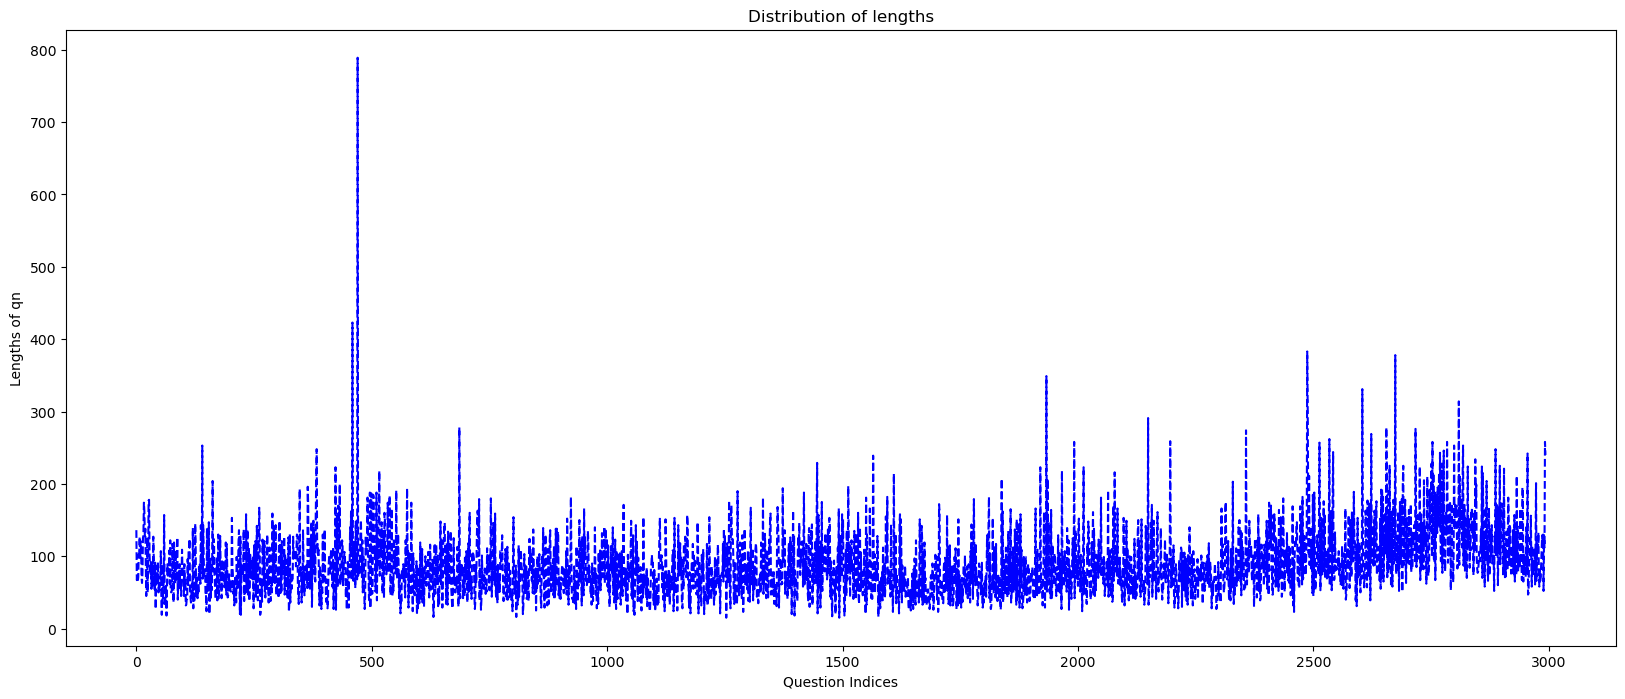

In [19]:
plt.figure(figsize=(20,8))
plt.plot(qns['qn'].str.split().apply(lambda qn: len(qn)), 'b--')
plt.xlabel('Question Indices')
plt.ylabel('Lengths of qn')
plt.title("Distribution of lengths")

## Modelling Process

Steps to be followed,
* `TfidfVectorizer` will be used to convert the text data into a vector representation
* `TruncatedSVD` will be used to reduce the dimensions of the data
* `StratifiedKFold` will be used as the validation method as the distribution of classes is imbalanced
* `RandomForestClassifier and LogisticRegression` will be used in their base forms without any hyperparameter tuning, so as to understand where the models go wrong
* Metric used will be `accuracy_score` and the `confusion_matrix` will be plotted to see which classes the models misinterpret

**Note**:<br>
The models mentioned above, be it the vectorizer or the dimensionality reduction model, all are subjectable to change based on the metric score. The primary goal is to make sure that text processing pipeline gives a good numeric representation of the text to be transformed

Before carrying out the steps above, it would be prudent to group the classes to a number where each class has a good number of instances that the models can learn from

Text(0, 0.5, 'Count')

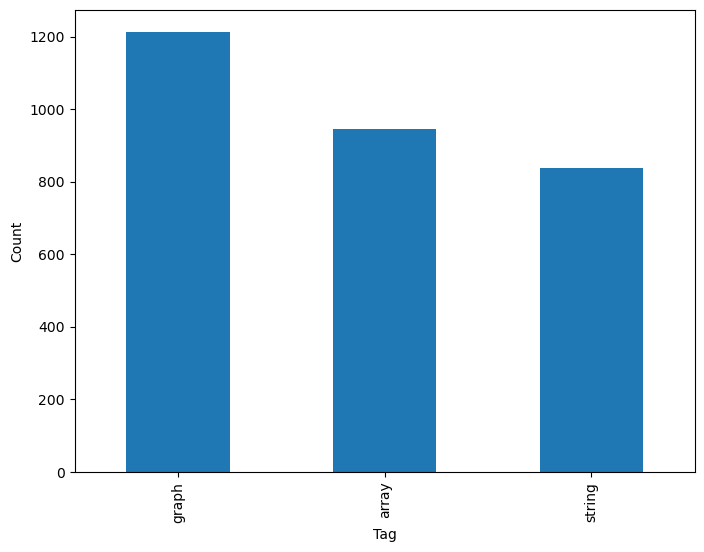

In [20]:
fig, ax = plt.subplots(1,1)
qns['tag'].value_counts().sort_values(ascending=False).plot.bar(figsize=(8,6),
                                                                ax=ax)
ax.set_xlabel('Tag')
ax.set_ylabel('Count')

In [21]:
classes = {key:value for value, key in enumerate(qns["tag"].unique())}
qns_sub = qns[qns["tag"].isin(classes.keys())]
qns_sub.reset_index(drop=True, inplace=True)

In [22]:
classes

{'graph': 0, 'array': 1, 'string': 2}

In [23]:
classes.keys()

dict_keys(['graph', 'array', 'string'])

### Creating training and test sets

The sets will be created in such a way that the ratio of target classes remains the same in both training and testing data. This is essential for the model to learn about the different classes equally and improves the model's generalizability<br>
In the subsequent preprocessing stages, all the preprocessing models will be trained on the training set to avoid data leakage.

In [24]:
qns_sub['tag'].unique()

array(['graph', 'array', 'string'], dtype=object)

In [25]:
qns_sub['tag'] = qns_sub['tag'].map(classes)

In [26]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(qns_sub['qn'], 
                                                                    qns_sub['tag'],
                                                                    test_size=TEST_SIZE,
                                                                    random_state=SEED,
                                                                    stratify=qns_sub['tag'])

In [27]:
y_train, y_test = y_train.values, y_test.values

### Vectorizing the text data

`TfidfVectorizer` from `scikit-learn` will be used initially.<br>
Depending on the model's performance other approaches might be selected in the future

In [28]:
vocab_sizes = [i for i in range(200, 1601, 100)]
accuracies = []

x_tr, x_val, y_tr, y_val = model_selection.train_test_split(X_train,
                                                           y_train,
                                                           test_size=0.1,
                                                           random_state=SEED,
                                                           stratify=y_train)

for vs in vocab_sizes:
    vectorizer_temp = TfidfVectorizer(max_features=vs)
    vectorizer_temp = vectorizer_temp.fit(x_tr)
    x_tr_vc = vectorizer_temp.transform(x_tr)
    x_val_vc = vectorizer_temp.transform(x_val)
    
    rfc = ensemble.RandomForestClassifier(random_state=SEED)
    rfc.fit(x_tr_vc, y_tr)
    val_pred = rfc.predict(x_val_vc)
    accuracies.append(metrics.accuracy_score(y_val, val_pred))

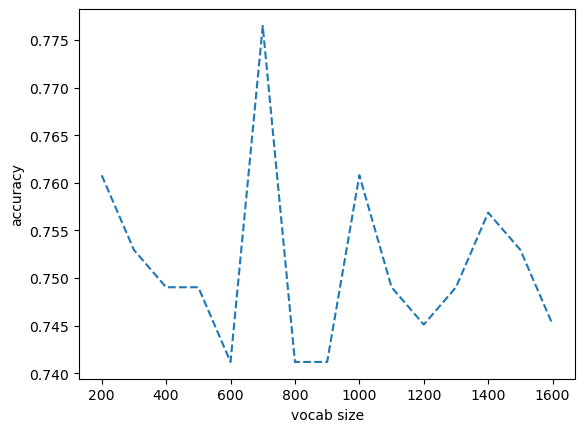

In [29]:
plt.plot(vocab_sizes, accuracies, ls='--')
plt.xlabel("vocab size")
plt.ylabel("accuracy");

In [30]:
vectorizer = TfidfVectorizer(max_features=700)
vectorizer = vectorizer.fit(X_train)

In [31]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [32]:
X_train.shape, X_test.shape

((2544, 700), (450, 700))

### StratifiedKFold split

In [33]:
skf = model_selection.StratifiedKFold(n_splits=10,
                                          shuffle=True,
                                          random_state=SEED)

models = [linear_model.LogisticRegression(random_state=SEED), 
          ensemble.RandomForestClassifier(random_state=SEED), 
          xgb.XGBClassifier(random_state=SEED),
          ensemble.AdaBoostClassifier(random_state=SEED),
          ensemble.GradientBoostingClassifier(random_state=SEED),
          lgb.LGBMClassifier(random_state=SEED)]

model_result_dict = {model.__class__.__name__:[] for model in models}

for fold, (tr, tt) in enumerate(skf.split(X_train, y_train)): 
   
    x_tr, x_tt = X_train[tr], X_train[tt]
    y_tr, y_tt = y_train[tr], y_train[tt]
    
    for model in models:
      model = model.fit(x_tr, y_tr)
      pred = model.predict(x_tt)
      model_result_dict[model.__class__.__name__].append(metrics.accuracy_score(y_tt, pred))
      # print(f"\t{model.__class__.__name__} accuracy: {metrics.accuracy_score(y_tt, pred)}")

In [34]:
skf_results = pd.DataFrame.from_dict(model_result_dict,
                      orient="index")
skf_results.columns = [f"fold_{i}" for i in range(1,11)]

In [35]:
skf_results["mean_acc"] = skf_results.iloc[:, :10].mean(axis=1)
skf_results["best_acc"] = skf_results.iloc[:, :10].max(axis=1)
skf_results["worst_acc"] = skf_results.iloc[:, :10].min(axis=1)
skf_results["std_acc"] = skf_results.iloc[:, :10].std(axis=1)

skf_results

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,mean_acc,best_acc,worst_acc,std_acc
LogisticRegression,0.745098,0.760784,0.745098,0.709804,0.704724,0.704724,0.700787,0.712598,0.688976,0.728346,0.720094,0.760784,0.688976,0.023452
RandomForestClassifier,0.800000,0.776471,0.784314,0.737255,0.775591,0.771654,0.779528,0.763780,0.767717,0.799213,0.775552,0.800000,0.737255,0.018052
XGBClassifier,0.749020,0.768627,0.788235,0.717647,0.767717,0.716535,0.732283,0.795276,0.728346,0.748031,0.751172,0.795276,0.716535,0.028113
AdaBoostClassifier,0.701961,0.729412,0.737255,0.690196,0.771654,0.712598,0.748031,0.692913,0.732283,0.720472,0.723678,0.771654,0.690196,0.025513
GradientBoostingClassifier,0.776471,0.772549,0.792157,0.752941,0.775591,0.740157,0.787402,0.771654,0.748031,0.767717,0.768467,0.792157,0.740157,0.016740
LGBMClassifier,0.772549,0.745098,0.772549,0.709804,0.783465,0.751969,0.751969,0.751969,0.744094,0.763780,0.754724,0.783465,0.709804,0.020520


In [36]:
if SHOULD_SAVE:
    skf_results.to_csv("../results/skf_results_10.csv")

### Confusion matrix

#### Helper function to visualize confusion matrix

In [37]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  # Create the confustion matrix
  cm = metrics.confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)
  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  ax.set_xticklabels(labels, rotation=90)
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

To know where the model is struggling we need to have a validation set. <br>
Let's create a temporary validation and training set

In [38]:
model = ensemble.RandomForestClassifier(random_state=SEED,
                          n_estimators=400)

X_tr, X_val, y_tr, y_val = model_selection.train_test_split(X_train, y_train,
                                                            random_state=SEED,
                                                            test_size=0.15,
                                                            stratify=y_train)

model = model.fit(X_tr, y_tr)
tr_pred = model.predict(X_tr)
val_pred = model.predict(X_val)

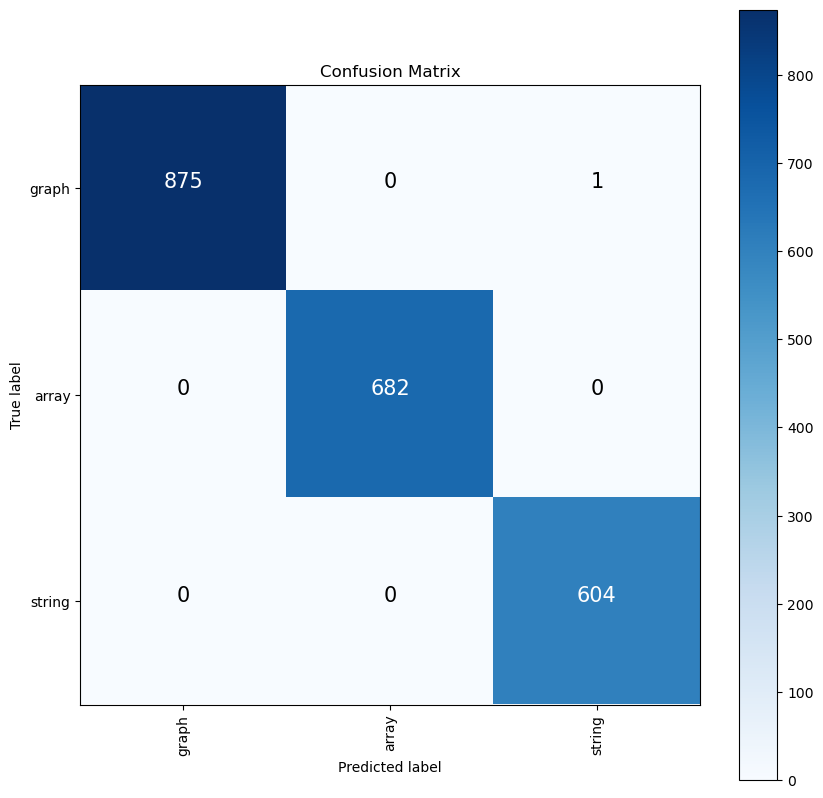

In [39]:
make_confusion_matrix(y_tr, tr_pred, classes=list(classes.keys()))

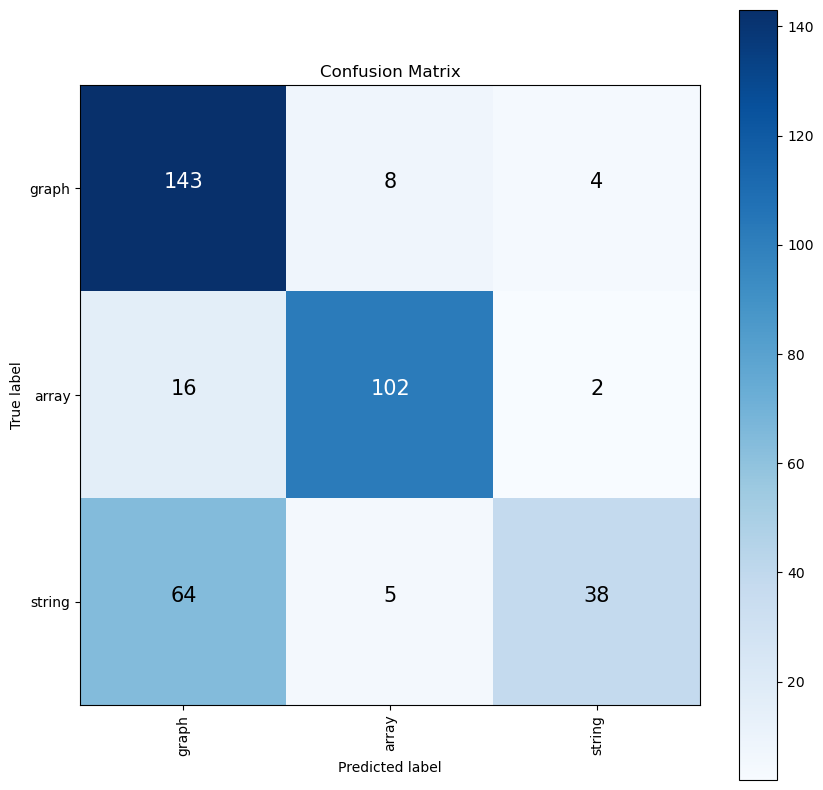

In [40]:
make_confusion_matrix(y_val, val_pred, classes=list(classes.keys()))

In [41]:
metrics.accuracy_score(y_val, val_pred)

0.7408376963350786

In [42]:
metrics.accuracy_score(y_val, [0]*len(y_val))

0.40575916230366493

In [43]:
tt_pred = model.predict(X_test)
metrics.accuracy_score(y_test, tt_pred), metrics.accuracy_score(y_test, [0]*len(y_test))

(0.7688888888888888, 0.40444444444444444)

## Pipeline models for PowerCoder

In [44]:
vocab_sizes = [i for i in range(200, 801, 100)]
n_estimators = [i for i in range(100, 401, 50)]

for vs in vocab_sizes:
    for n_estimator in n_estimators:
        rfc_pipe = Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=vs)),
                                  ('clf', ensemble.RandomForestClassifier(n_estimators=n_estimator, random_state=SEED))])
        xgb_pipe = Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=vs)),
                                  ('clf', xgb.XGBClassifier(n_estimators=n_estimator, random_state=SEED))])
        
        rfc_pipe.fit(qns_sub['qn'], qns_sub['tag'].values)
        xgb_pipe.fit(qns_sub['qn'], qns_sub['tag'].values)
        
        pickle.dump(rfc_pipe, open(f'../models/rfc_{n_estimator}_vect_{vs}.sav', 'wb'))
        pickle.dump(xgb_pipe, open(f'../models/xgb_{n_estimator}_vect_{vs}.sav', 'wb'))

### Pipeline + GridSearchCV

In [45]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(qns_sub["qn"],
                                                                    qns_sub["tag"],
                                                                   test_size=0.15,
                                                                   random_state=SEED,
                                                                   stratify=qns_sub["tag"])

Pipeline is going to consist of `TfIdfVectorizer` and `RandomForestClassifier`

In [46]:
vectorizer = TfidfVectorizer()
rfc = ensemble.RandomForestClassifier(random_state=SEED)

pipeline = Pipeline(steps=[("vectorizer", vectorizer), ("rfc", rfc)])
param_grid = {
    "vectorizer__max_features" : np.arange(1500, 2501, 100),
    "rfc__n_estimators" : np.arange(100, 601, 100),
    "rfc__max_depth" : [None] + [i for i in range(6, 13)]
}

search = model_selection.GridSearchCV(pipeline,
                                     param_grid=param_grid,
                                     n_jobs=-1,
                                     scoring="accuracy",
                                     cv=model_selection.StratifiedKFold(n_splits=5),
                                     return_train_score=True)
search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(random_state=2406))]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': [None, 6, 7, 8, 9, 10, 11, 12],
                         'rfc__n_estimators': array([100, 200, 300, 400, 500, 600]),
                         'vectorizer__max_features': array([1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500])},
             return_train_score=True, scoring='accuracy')

In [47]:
search.best_score_

0.784982132636171

In [48]:
search.best_estimator_

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=2200)),
                ('rfc',
                 RandomForestClassifier(n_estimators=200, random_state=2406))])